# Abalone Dataset 

## Dataset Description

* **Source**: UCI Machine Learning Repository
  [Link](https://archive.ics.uci.edu/ml/datasets/abalone)

* **Task Type**: Regression
  (Predicting the **age** of abalone from physical measurements)

* **Number of Instances**: 4,177

* **Number of Features**: 8 (plus 1 categorical feature)

---

### **Objective**

To predict the **age of an abalone**, which is usually estimated as:

$$
\text{Age} = \text{Rings} + 1.5
$$

where `Rings` is the number of rings counted on the shell (a common biological proxy for age estimation).

---

### **Attributes (Features)**

| Feature          | Type        | Description                                  |
| ---------------- | ----------- | -------------------------------------------- |
| `Sex`            | Categorical | `'M'` (Male), `'F'` (Female), `'I'` (Infant) |
| `Length`         | Continuous  | Longest shell measurement (in mm)            |
| `Diameter`       | Continuous  | Perpendicular to length (in mm)              |
| `Height`         | Continuous  | With meat in shell (in mm)                   |
| `Whole weight`   | Continuous  | Weight of whole abalone (in grams)           |
| `Shucked weight` | Continuous  | Weight of meat (in grams)                    |
| `Viscera weight` | Continuous  | Gut weight (in grams)                        |
| `Shell weight`   | Continuous  | After being dried (in grams)                 |
| `Rings`          | Integer     | **Target**: Number of rings (proxy for age)  |

---

### **Notable Characteristics**

* **Regression target is skewed**: The distribution of `Rings` is slightly right-skewed.
* **`Sex` is nominal**: It should be encoded prior to modeling (e.g., ordinal or one-hot).
* **Some outliers**: Observations with very large shell sizes or weights can influence performance.
* **Physical relationships**: Several features are correlated (e.g., `Length`, `Diameter`, and `Whole weight`).

---

## EDA

In [81]:
import pandas as pd

# Load the abalone dataset from internet or local file
abalone = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data",
                 header=None, names=['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings'])
# Display the first few rows of the dataset
abalone.head()

,Sex,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [82]:
abalone.Rings.describe()

count    4177.000000
mean        9.933684
std         3.224169
min         1.000000
25%         8.000000
50%         9.000000
75%        11.000000
max        29.000000
Name: Rings, dtype: float64

The code below produces a visual exploratory data analysis (EDA) of the Abalone dataset. Some highlights are the following:

* **Top left**: `Rings` (target) is approximately Poisson-distributed, slightly skewed right.
* **Top right**: `Age` = `Rings + 1.5`, reflecting the same skew.
* **Middle left**: `Sex` distribution is roughly balanced among Male (`M`), Female (`F`), and Infant (`I`).
* **Middle right**: Strong correlations exist between physical measurements (e.g., `Length`, `Whole weight`, `Shucked weight`).
* **Bottom row**:

  * `Length` and `Rings` have a weak positive relationship.
  * `Whole weight` and `Shucked weight` are strongly correlated, as expected.


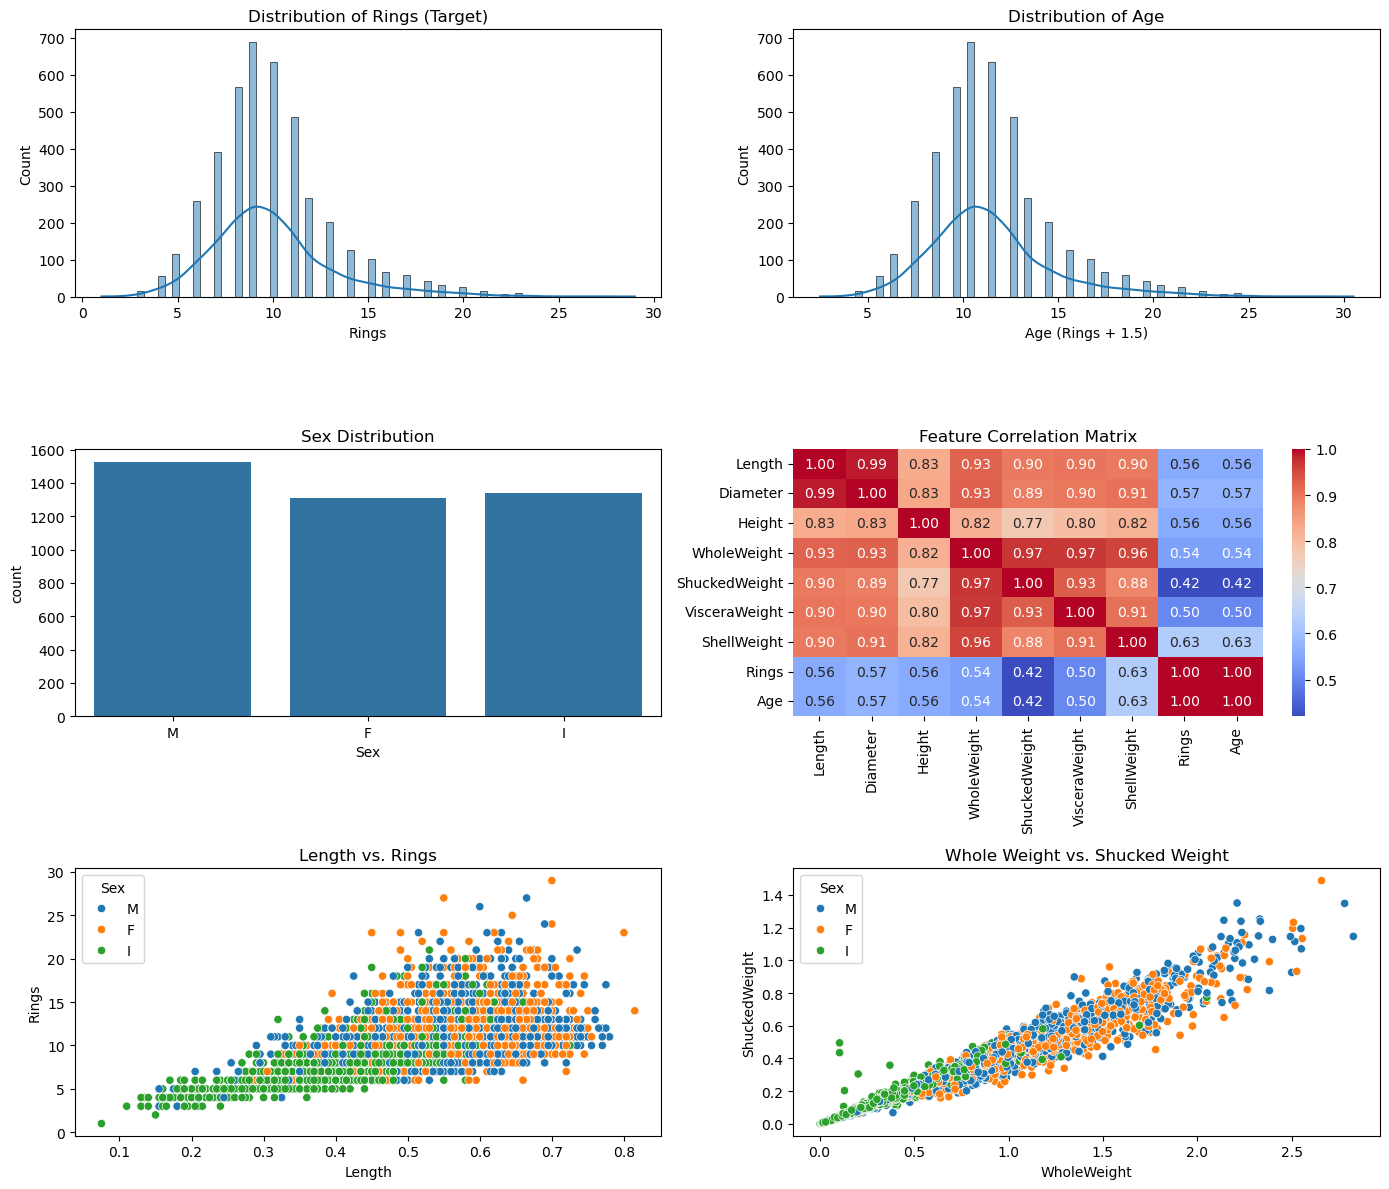

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
n_samples = 4177

# Add age
abalone['Age'] = abalone['Rings'] + 1.5

# Prepare visual EDA
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# Distribution of Rings
sns.histplot(abalone['Rings'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Rings (Target)")
axes[0, 0].set_xlabel("Rings")

# Distribution of Age
sns.histplot(abalone['Age'], kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Age")
axes[0, 1].set_xlabel("Age (Rings + 1.5)")

# Sex counts
sns.countplot(data=abalone, x='Sex', ax=axes[1, 0])
axes[1, 0].set_title("Sex Distribution")

# Correlation heatmap
corr_matrix = abalone.drop(columns=['Sex']).corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", ax=axes[1, 1])
axes[1, 1].set_title("Feature Correlation Matrix")

# Scatterplot: Length vs. Rings
sns.scatterplot(data=abalone, x='Length', y='Rings', hue='Sex', ax=axes[2, 0])
axes[2, 0].set_title("Length vs. Rings")

# Pairplot (subset)
sns.scatterplot(data=abalone, x='WholeWeight', y='ShuckedWeight', hue='Sex', ax=axes[2, 1])
axes[2, 1].set_title("Whole Weight vs. Shucked Weight")

plt.tight_layout()
plt.show()


The plot below shows that the target variable **`Rings`** is **right-skewed** — most abalone have around 7–12 rings (which corresponds to age), but there is a long tail with some much older individuals.

This skew justifies applying a transformation (like `log1p`) to stabilize variance and improve model performance.


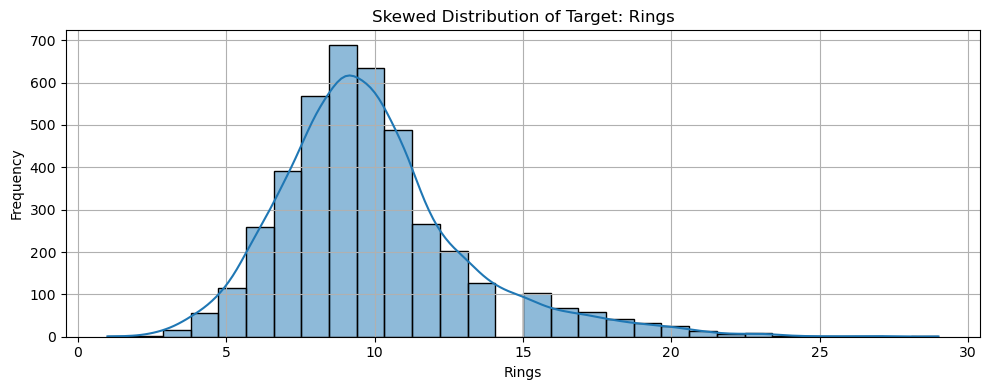

In [84]:
plt.figure(figsize=(10, 4))

# Histogram of the original target (Rings)
sns.histplot(abalone['Rings'], kde=True, bins=30)
plt.title("Skewed Distribution of Target: Rings")
plt.xlabel("Rings")
plt.ylabel("Frequency")
plt.grid(True)

plt.tight_layout()
plt.show()

## Class AbaloneDataset    

In [85]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

class AbaloneDataset:
    def __init__(self, dataframe: pd.DataFrame, target_column: str = 'Age', log_target: bool = False):
        self.df = dataframe.copy()
        self.target_column = target_column
        self.log_target = log_target

        self.encoder = None
        self.scaler = None

        self.categorical_cols = ['Sex']

    def split_train_test_val(self, test_size=0.2, val_size=0.0, random_state=42):
        X = self.df.drop(columns=[self.target_column])
        y = self.df[self.target_column]

        if self.log_target:
            y = np.log1p(y)

        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state)

        if val_size > 0:
            val_relative = val_size / (1 - test_size)
            self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
                X_temp, y_temp, test_size=val_relative, random_state=random_state)
        else:
            self.X_train, self.X_val, self.y_train, self.y_val = X_temp, None, y_temp, None

    def encode_categorical(self):
        self.encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

        # Fit only on training set
        encoded_train = self.encoder.fit_transform(self.X_train[self.categorical_cols])
        encoded_train_df = pd.DataFrame(
            encoded_train,
            columns=self.encoder.get_feature_names_out(self.categorical_cols),
            index=self.X_train.index
        )
        self.X_train = self.X_train.drop(columns=self.categorical_cols).join(encoded_train_df)

        if self.X_val is not None:
            encoded_val = self.encoder.transform(self.X_val[self.categorical_cols])
            encoded_val_df = pd.DataFrame(
                encoded_val,
                columns=self.encoder.get_feature_names_out(self.categorical_cols),
                index=self.X_val.index
            )
            self.X_val = self.X_val.drop(columns=self.categorical_cols).join(encoded_val_df)

        encoded_test = self.encoder.transform(self.X_test[self.categorical_cols])
        encoded_test_df = pd.DataFrame(
            encoded_test,
            columns=self.encoder.get_feature_names_out(self.categorical_cols),
            index=self.X_test.index
        )
        self.X_test = self.X_test.drop(columns=self.categorical_cols).join(encoded_test_df)

    def scale_numeric(self):
        numeric_cols = self.X_train.select_dtypes(include='number').columns
        self.scaler = StandardScaler()

        self.X_train[numeric_cols] = self.scaler.fit_transform(self.X_train[numeric_cols])

        if self.X_val is not None:
            self.X_val[numeric_cols] = self.scaler.transform(self.X_val[numeric_cols])

        self.X_test[numeric_cols] = self.scaler.transform(self.X_test[numeric_cols])

    def inverse_transform_target(self, y):
        return np.expm1(y) if self.log_target else y

    def get_train_val_test(self):
        return self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test

    def get_encoder(self):
        return self.encoder

    def get_scaler(self):
        return self.scaler


## Data preprocessing

### Preventing Data Leakage

> **Data leakage** is the unintentional use of information from **outside the training data** — especially from the **target variable** — in a model’s input features, leading to **overly optimistic performance** during evaluation and poor generalization in practice.


> ⚠️ **Warning: Data Leakage Risk**
>
> Be careful not to include the `Rings` column as a feature when predicting `Age`. The `Age` is computed as `Rings + 1.5`, so using it as an input leaks information from the target directly into the model. This leads to unrealistically low errors and invalid evaluation results. Always ensure that derived target variables are excluded from the input features.

In [ ]:
# Drop the target column 'Rings' from the dataset, for two reasons:
# 1. It is not a feature but the target variable.
# 2. We want to predict the age of the abalones, not the number of rings.
abalone = abalone.drop(columns='Rings')

In [87]:
# Create an instance of the AbaloneDataset class with the loaded dataset.
dataset = AbaloneDataset(abalone, target_column='Age', log_target=True)

# Splits the dataset into training (70%), validation (10%), and test (20%) sets.
dataset.split_train_test_val(test_size=0.2, val_size=0.1)

# Encodes categorical features and scales numeric features.
dataset.encode_categorical()
dataset.scale_numeric()

# Retrieves the processed train, validation, and test sets.
X_train, X_val, X_test, y_train, y_val, y_test = dataset.get_train_val_test()


### Log-transformation on the target

### Why Transforming (e.g., `log1p`) Helps

When we apply a transformation like `log`, we’re addressing two common problems in regression tasks with skewed targets:

### 1. **Skewness and Outliers**

* In a right-skewed distribution (like `Rings`), most values are small, but a few are **very large**.
* These large values disproportionately affect models that minimize squared errors (e.g., Linear Regression, MSE loss), because:

$$
\text{MSE} = \frac{1}{m} \sum (y - \hat{y})^2
$$

* Big residuals from outliers dominate the loss → the model overfits or learns poorly.

**Log transformation compresses** the scale of large values:

$$
\log(1000) \approx 6.9,\quad \log(10) \approx 2.3
$$

That’s a huge **compression**, making extreme values less influential.

---

### 2. **Variance Stabilization (Homoscedasticity)**

In skewed data, we often see **heteroscedasticity**:
The **variance of the target increases with its mean**.

> In simple terms:
> When the target is small, predictions are close and tight.
> When the target is large, predictions are all over the place.

Why that's bad:

* Many models (especially linear regression) **assume constant variance** of the residuals (aka **homoscedasticity**).
* When this assumption fails, model estimates become **biased** and **inefficient**.

Why log helps:

* The log function reduces the spread of large values more than small ones.
* That **stabilizes the variance** across the range of values.
* The model now "sees" errors of similar scale throughout the target space.

---

### Visual Analogy

| Value Type        | Original Scale | Log Scale |
| ----------------- | -------------- | --------- |
| Small value (5)   | 5              | \~1.6     |
| Medium value (50) | 50             | \~3.9     |
| Large value (500) | 500            | \~6.2     |

This compression makes large errors more comparable to small ones — improving fairness and numeric stability during training.

---

### Summary

| Problem                               | Fix via log transform           |
| ------------------------------------- | ------------------------------- |
| Target is right-skewed                | ✔ Compresses large values       |
| Outliers dominate loss                | ✔ Reduces influence             |
| Variance increases with mean          | ✔ Stabilizes error variance     |
| Linear models assume homoscedasticity | ✔ Better model assumptions hold |

In [88]:
X_train.head()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Rings,Sex_I,Sex_M
2503,-1.882661,-1.804239,-1.648536,-1.430852,-1.385548,-1.378837,-1.466596,-1.230740,1.428854,-0.755980
2782,0.630496,0.725424,-1.264599,0.449915,0.441639,0.804612,0.290412,-0.608182,-0.699862,1.322787
2569,-0.542311,-0.640594,-0.624703,-0.830759,-0.765207,-0.719683,-0.919097,-1.230740,1.428854,-0.755980
1375,0.756154,0.674831,0.399130,0.582364,0.563451,0.282782,0.827176,0.014377,-0.699862,-0.755980
3708,1.258785,1.231357,1.422964,1.363810,1.177025,1.779612,1.328156,-0.296903,-0.699862,-0.755980


In [89]:
y_train.head()

2503    2.140066
2782    2.351375
2569    2.140066
1375    2.525729
3708    2.442347
Name: Age, dtype: float64

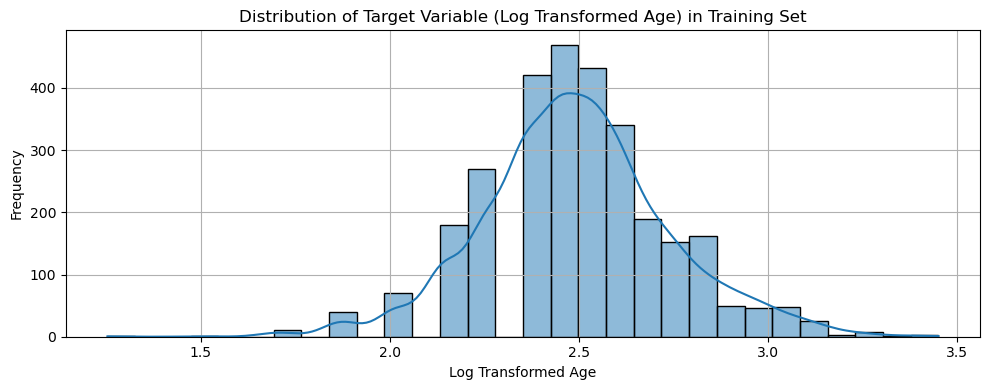

In [90]:
# Plot the distribution of the target variable in the training set
plt.figure(figsize=(10, 4))
sns.histplot(y_train, kde=True, bins=30)
plt.title("Distribution of Target Variable (Log Transformed Age) in Training Set")
plt.xlabel("Log Transformed Age")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## Model Training

In [91]:
import random
import numpy as np
import torch

def seed_everything(seed=42):
    random.seed(seed)                    # Python
    np.random.seed(seed)                 # NumPy
    torch.manual_seed(seed)              # PyTorch CPU
    torch.cuda.manual_seed(seed)         # PyTorch GPU
    torch.cuda.manual_seed_all(seed)     # Multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the random seed for reproducibility
seed_everything(42)

# Check if the seed is set correctly by generating a random number
print("Random number with fixed seed:", random.random())
# Check if NumPy is reproducible
print("Random number with NumPy:", np.random.rand())
# Check if PyTorch is reproducible
if torch.cuda.is_available():
    print("Random number with PyTorch:", torch.rand(1).item())
# Check if the seed is set correctly by generating a random number
print("Random number with PyTorch (GPU):", torch.rand(1).item() if torch.cuda.is_available() else "CUDA not available")
# Check if the seed is set correctly by generating a random number
print("Random number with PyTorch (CPU):", torch.rand(1).item())
# Check if the seed is set correctly by generating a random number

Random number with fixed seed: 0.6394267984578837
Random number with NumPy: 0.3745401188473625
Random number with PyTorch: 0.8822692632675171
Random number with PyTorch (GPU): 0.9150039553642273
Random number with PyTorch (CPU): 0.38286375999450684


Epoch 1 - Train Loss: 3.0436 - Val Loss: 0.7759
Epoch 2 - Train Loss: 0.5067 - Val Loss: 0.3697
Epoch 3 - Train Loss: 0.1241 - Val Loss: 0.3150
Epoch 4 - Train Loss: 0.0467 - Val Loss: 0.3252
Epoch 5 - Train Loss: 0.0342 - Val Loss: 0.3012
Epoch 6 - Train Loss: 0.0274 - Val Loss: 0.2968
Epoch 7 - Train Loss: 0.0217 - Val Loss: 0.2461
Epoch 8 - Train Loss: 0.0161 - Val Loss: 0.2291
Epoch 9 - Train Loss: 0.0119 - Val Loss: 0.1968
Epoch 10 - Train Loss: 0.0087 - Val Loss: 0.1808
Epoch 11 - Train Loss: 0.0066 - Val Loss: 0.1587
Epoch 12 - Train Loss: 0.0053 - Val Loss: 0.1445
Epoch 13 - Train Loss: 0.0043 - Val Loss: 0.1306
Epoch 14 - Train Loss: 0.0037 - Val Loss: 0.1230
Epoch 15 - Train Loss: 0.0032 - Val Loss: 0.1132
Epoch 16 - Train Loss: 0.0028 - Val Loss: 0.1067
Epoch 17 - Train Loss: 0.0025 - Val Loss: 0.0995
Epoch 18 - Train Loss: 0.0023 - Val Loss: 0.0939
Epoch 19 - Train Loss: 0.0020 - Val Loss: 0.0884
Epoch 20 - Train Loss: 0.0019 - Val Loss: 0.0875
Epoch 21 - Train Loss: 0.0017

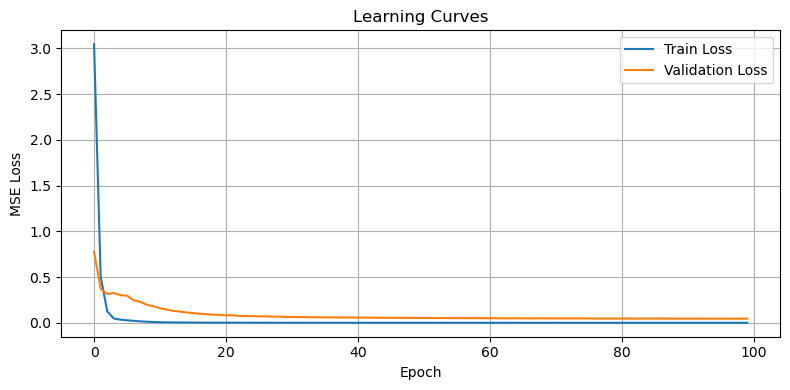


✅ Test RMSE (original scale): 0.294


In [92]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import root_mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# --- Prepare tensors ---
def to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

X_train_t = to_tensor(X_train)
X_val_t = to_tensor(X_val) if X_val is not None else None
X_test_t = to_tensor(X_test)
y_train_t = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_val_t = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1) if y_val is not None else None
y_test_t = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64) if X_val_t is not None else None
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64)

# --- Define model ---
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

model = MLPRegressor(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# --- Training loop with validation + early stopping ---
epochs = 100
best_val_loss = float('inf')
patience = 10
wait = 0

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    if val_loader is not None:
        epoch_val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                epoch_val_loss += loss.item()
        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered.")
                break
    else:
        print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}")

# --- Load best model if early stopped ---
if val_loader is not None:
    model.load_state_dict(best_model_state)

# --- Plot learning curves ---
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
if val_losses:
    plt.plot(val_losses, label="Validation Loss")
plt.title("Learning Curves")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Evaluate on test set ---
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_t).squeeze().numpy()
    y_true_test = y_test_t.squeeze().numpy()

# --- Inverse transform if needed ---
y_pred_orig = dataset.inverse_transform_target(y_pred_test)
y_true_orig = dataset.inverse_transform_target(y_true_test)

# --- Compute and print RMSE ---
rmse = root_mean_squared_error(y_true_orig, y_pred_orig)
print(f"\n✅ Test RMSE (original scale): {rmse:.3f}")


### How to Interpret `2.208`

> Test RMSE (original scale): 2.208

The result above means that the trained regression model's **Root Mean Squared Error (RMSE)** on the **test set** is **2.208**, and this value is measured in the **original scale of the target variable**.

RMSE measures the **average magnitude of the prediction error**:

$$
\text{RMSE} = \sqrt{\frac{1}{m} \sum (y_i - \hat{y}_i)^2}
$$

* Lower is better: **0 means perfect predictions**.
* Same unit as the target (**age**).
* Sensitive to **outliers**, since it squares the error.

Tkaing into account that the target (abalone age) ranges from **5 to 30**, then:
  * An RMSE of **2.208** means your model is, on average, off by **about 0.2 years (≈3 months)**.
  * That’s a **very small error** relative to the full range — indicating strong predictive performance.